# Expression heatmap in scRNA-seq data

We examine the expression of ASD risk genes in the raw single-nucleus RNA-seq data downloaded from http://resource.psychencode.org/. This count data is UMI-based, merged from two sources [Lake et al. (2018)](https://doi.org/10.1038/nbt.4038) and [Wang et al. (2018)](https://doi.org/10.1126/science.aat8464).

### Download data

In [1]:
rm(list = ls())
options(stringsAsFactors = FALSE)

suppressWarnings(suppressMessages(library(tidyverse)))
library(readxl)

system("curl http://adult.psychencode.org/Datasets/Derived/SC_Decomp/DER-22_Single_cell_expression_raw_UMI.tsv --output DER-22_Single_cell_expression_raw_UMI.tsv")

### Load and munge expression data

In [2]:
lake_expr <- read.table("DER-22_Single_cell_expression_raw_UMI.tsv", sep = "\t")  # 17176 genes, 27412 cells
#glimpse(lake_expr)

lake_annot <- data.frame("cell_id" = colnames(lake_expr))
lake_annot$level2class <- gsub("\\..*","", lake_annot$cell_id)
lake_annot$level1class <- lake_annot$level2class
lake_annot$level1class[grep("Ex", lake_annot$level1class)] <- "ExcNeu"
lake_annot$level1class[grep("In", lake_annot$level1class)] <- "InNeu"

idx <- which(lake_annot$level1class == "NA")
lake_annot <- lake_annot[-idx, ]
lake_expr <- lake_expr[, -idx]  # 17176 genes, 27380 cells
#table(lake_annot$level2class)

### Download ASD risk genes

In [3]:
system("curl https://www.cell.com/cms/10.1016/j.neuron.2015.09.016/attachment/604dfb89-c9ec-486f-8a49-db9d62510915/mmc7.xlsx --output mmc7.xlsx")

ASD_Sanders <- read_excel("/Users/minsookim/Dropbox/MG/gene-list/list/mmc7.xlsx")
ASD_Sanders <- filter(ASD_Sanders, tadaFdrAscSscExomeSscAgpSmallDel < 0.1)

### Subset to genes of interest and tidy data

In [4]:
df <- lake_expr %>% 
  filter(rownames(.) %in% ASD_Sanders$RefSeqGeneName) %>% 
  mutate(gene = rownames(.)) %>% 
  gather(key = cell_id, value = expression, -gene) %>% 
  left_join(lake_annot, by = "cell_id") %>% 
  group_by(gene) %>% 
  mutate(`mean count` = mean(expression),
         `sd count` = sd(expression)) %>% 
  filter(`mean count` > 0) %>% 
  ungroup()

df[df$level1class == "Microglia", c("level1class", "level2class")] <- "Mic"  # rename microglia

### Cluster similar genes based on expression profile

In [5]:
df_order <- df %>% 
  group_by(level1class, level2class, gene) %>% 
  summarize(`avg count` = mean(expression), .groups = "drop") %>% 
  select(-level1class) %>% 
  spread(key = level2class, value = `avg count`) %>%
  as.data.frame()

rownames(df_order) <- df_order$gene
df_order <- df_order[, -1]

tree <- hclust(dist(df_order), "ward.D2")

df$gene <- factor(df$gene, levels = rownames(df_order)[tree$order])

### Plot average expression per cell-subtype

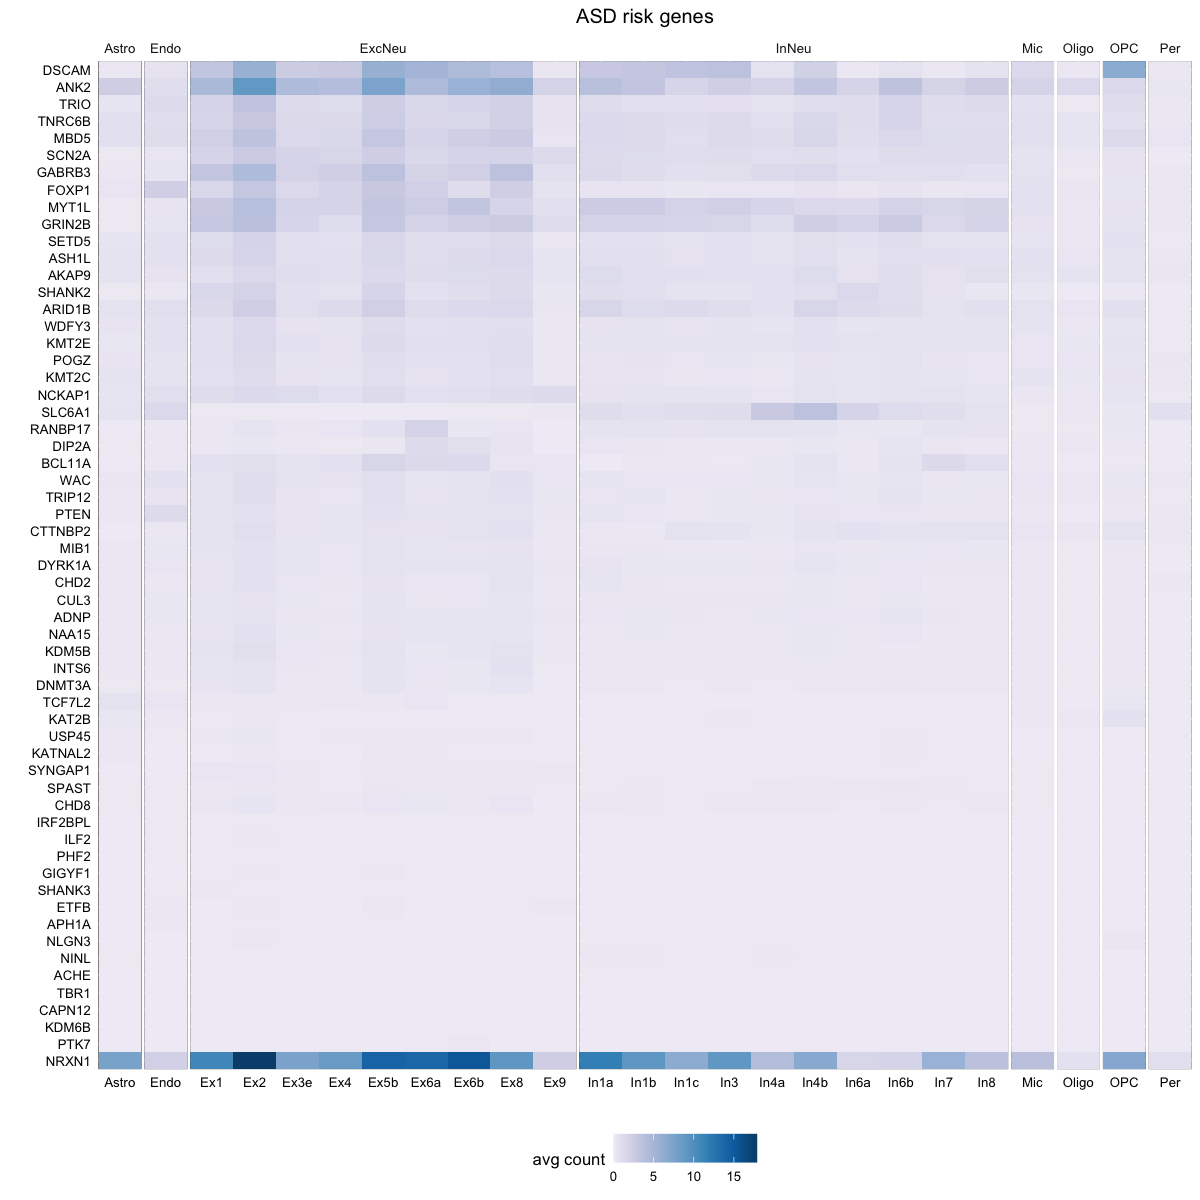

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)

df %>% 
  group_by(level1class, level2class, gene) %>% 
  summarize(`avg count` = mean(expression), .groups = "drop") %>% 
  ggplot(aes(x = level2class, y = gene, fill = `avg count`)) + 
  geom_tile() +
  scale_fill_distiller(type = "seq", palette = 9, direction = 1) +
  theme_grey(base_size = 10) + 
  scale_x_discrete(expand = c(0, 0)) + 
  scale_y_discrete(expand = c(0, 0)) + 
  labs(x = "", y = "") +
  facet_grid(. ~ level1class, scales = "free", space = "free") +
  ggtitle("ASD risk genes") +
  theme(axis.ticks = element_blank(), 
        axis.text = element_text(colour = "black"), 
        panel.spacing = unit(0.125, "lines"),
        strip.placement = "inside",
        strip.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        panel.background = element_rect(colour = "black", size = 1),
        legend.position = "bottom")

### Plot scaled expression per cell

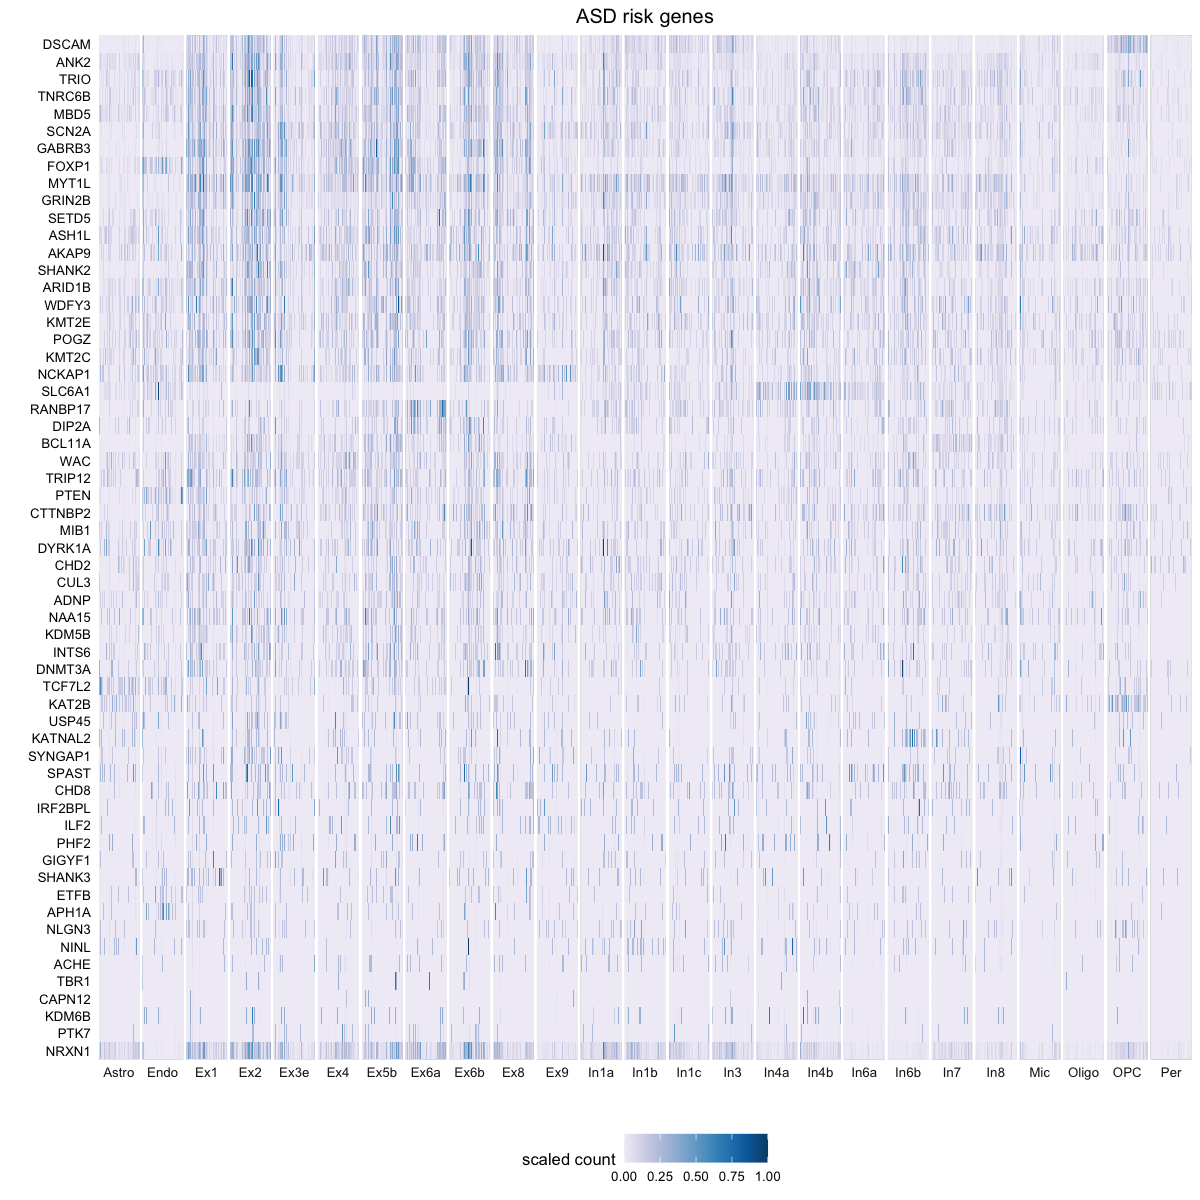

In [7]:
df %>% 
  group_by(gene) %>% 
  mutate(`scaled count` = expression / max(expression)) %>% 
  ungroup() %>%  
  ggplot(aes(x = cell_id, y = gene, fill = `scaled count`)) + 
  geom_tile() +
  scale_fill_distiller(type = "seq", palette = 9, direction = 1) +
  theme_grey(base_size = 10) + 
  scale_x_discrete(expand = c(0, 0)) + 
  scale_y_discrete(expand = c(0, 0)) + 
  labs(x = "", y = "") +
  facet_grid(. ~ level2class, scales = "free", switch = "x") +
  ggtitle("ASD risk genes") +
  theme(axis.ticks = element_blank(),
        axis.text = element_text(colour = "black"),
        axis.text.x = element_blank(), 
        panel.spacing = unit(0.125, "lines"),
        strip.placement = "inside",
        plot.title = element_text(hjust = 0.5),
        panel.background = element_rect(colour = "black", size = 1),
        legend.position = "bottom",
        strip.background = element_blank())

#ggsave("lake-heatmap.png", width = 649, height = 699, scale = 1/100, dpi = 600)